# Week 8 - Object Detection Assignments

If we specifically ask you to code a function, please do not use any available implementations directly from packages.

## Question 1

Part 0: Compare **one-stage object detectors** and **two-stage object detectors**.

Part 1: Why is **Faster-RCNN** slow?

Part 2: Why or how is **YOLO** so damn fast? 

Part 3: What is the improvement of **SSD** over **YOLO**? 

Write your answer to the cell below. Please try to give a detailed answer for each part.

**Answer**:

Part 0:
One-stage detectors are faster than two-stage detectors but generally have lower mean average precision (mAP).

Part 1: 
Even though the region proposal network is faster than Fast-RCNN due to being fully convolutional, it is still a two-stage detector which makes it relatively slower than one-stage detectors such as YOLO and SDD.

Part 2:
 Since it breaks the problem into smaller tasks (divide and conquer), it can achieve better parallelism and become faster.

 Part 3:
It achieves faster results by being fully convolutional.

## Question 2

**Non-Maximum Supression (NMS)** is used when there are multiple bounding boxes overlapping each other, belonging to the same object.

<p align="center">
<img src="img/nms.PNG" alt="NMS" width="650"/>
</p>

Here, $\lambda_{nms}$ is a predefined hyperparameter that determines the threshold for "overlapping".

Code NMS.


Note: You can use Google Colab to easily run this notebook. If you want to use your own machine, first, you will need to comment the
`from google.colab.patches import cv2_imshow` 
line in the cell below. 

Then you will need to replace the `cv2_imshow(image)` lines with the following lines:
```
cv2.imshow("lenna", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
```
This way, openCV will show the image in a new window. To exit the window DO NOT CLICK ON THE RED CROSS, just press any button on the keyboard, otherwise you may need to restart your notebook.

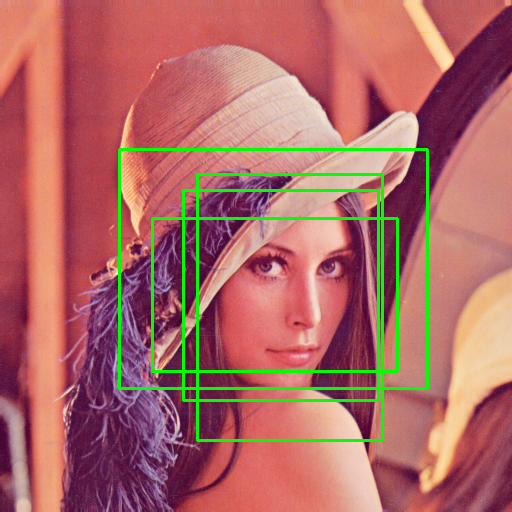

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# If working on colab, upload the lenna.jpg file:
image = cv2.imread("lenna.jpg")

cv2.rectangle(image, (119, 149), (427, 388), (0, 255, 0), 2)
cv2.rectangle(image, (152, 218), (397, 371), (0, 255, 0), 2)
cv2.rectangle(image, (197, 174), (382, 440), (0, 255, 0), 2)
cv2.rectangle(image, (183, 190), (378, 400), (0, 255, 0), 2)

cv2_imshow(image)

In [ ]:
def non_max_suppression(boxes, scores):
  # Write the code for NMS here

  nms_discard = np.zeros(len(boxes))
  for i, b1 in enumerate(boxes):
    for j, b2 in enumerate(boxes):
      if scores[j] > scores[i]:
        nms_discard[i] = 1

  nms_boxes = []
  for i, d in enumerate(nms_discard):
    if not d:
      nms_boxes.append(boxes[i])
  return nms_boxes

In [ ]:
boxes = [[119, 149, 427, 388], [152, 218, 397, 371], [197, 174, 382, 440], [183, 190, 378, 400]]
scores = [0.78, 0.92, 0.85, 0.82]

updated_boxes = non_max_suppression(boxes, scores)
updated_boxes

[[152, 218, 397, 371]]

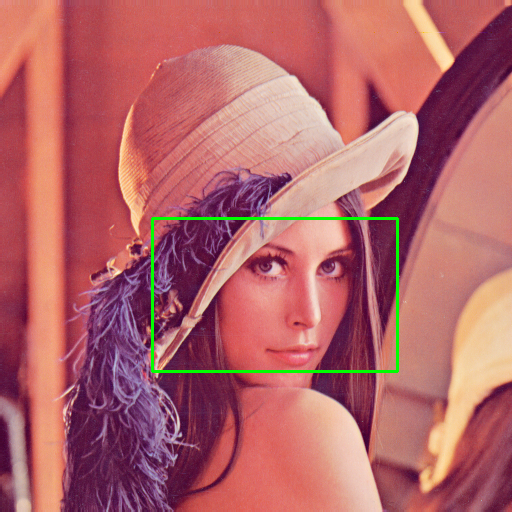

In [ ]:
image = cv2.imread("lenna.jpg")

# Enter the coordinates of the "updated_boxes" below:
cv2.rectangle(image, (152, 218), (397, 371), (0, 255, 0), 2)

cv2_imshow(image)

Can you backpropagate through NMS?

**Answer**:
Nope. We should first remove the loops and make a soft NMS!

**Bonus:** If the answer is yes, we dare you to code it.

Hint: You can check out some papers on learnable NMS online.

In [ ]:
# Code learnable NMS here. You can use any package that you want.

## Question 3

This question consists of four parts:

1. Write the code of **Spatial Pyramid Pooling (SPP)** operation.
1. Write the code of **RoIPool** operation.
1. Write the code of **RoIAlign** operation.
1. Compare the three methods in terms of their advantages and disadvantages.

### Part 1: Spatial Pyramid Pooling (SPP)

There is no need for flattening convolution features into 1D and then feed them to fully connected layers anymore! Since fully connected layers only accept fixed-size input, convolutional neural networks also only accepted fixed size input (most commonly $224 \times 224$) for a while.

Spatial Pyramid Pooling (SPP) keeps the spatial information of the feature maps in local spatial bins. The sizes of these bins, and the number of bins are all fixed. Responses of the filters are pooled in each spatial bin. (In the original [paper](https://arxiv.org/abs/1406.4729), authors use max pooling).



<p align="center">
<img src="img/spp.PNG" alt="NMS" width="500"/>
</p>

<center>
Image source: <a href="https://arxiv.org/abs/1406.4729">Paper</a>
</center>

Code SPP with any framework you want. Your function should take output feature maps of a convolutional layer as input, and should give a fixed size output, whatever the size of the input feature maps.


In [ ]:
# A random feature map, belonging to one image:

import numpy as np
np.random.seed(3) # change the seed for different inputs

num_filters = np.random.choice([64, 128, 256])
height = np.random.randint(12, 42)
width = height

feature_maps = np.random.randn(num_filters, height, width)
print(feature_maps.shape)

(256, 36, 36)


In [ ]:
import torch
import torch.nn.functional as F
def spatial_pyramid_pooling(feature_maps, levels):
  # code for SPP will be written here
  feature_maps = torch.tensor(feature_maps)

  num_filters, feature_height, feature_width = feature_maps.shape
  size1 = feature_height // levels[0], feature_width // levels[0]
  size2 = feature_height // levels[1], feature_width // levels[1]
  size3 = feature_height // levels[2], feature_width // levels[2]
  pool1 = F.max_pool2d(feature_maps, kernel_size=size1).view(num_filters, -1)
  pool2 = F.max_pool2d(feature_maps, kernel_size=size2).view(num_filters, -1)
  pool3 = F.max_pool2d(feature_maps, kernel_size=size3).view(num_filters, -1)
  pooled = torch.cat([pool1, pool2, pool3], axis=1)
  return pooled

If the levels are ```[1, 2, 4]```, and the filter size of the feature maps is $64$, then the output of SPP should be $64 \times 1 + 64 \times 4 + 64 \times 16 = 64 \times 21$

In [ ]:
# Test
num_filters = 64
height = np.random.randint(12, 42)
width = height

feature_maps = np.random.randn(num_filters, height, width)
print('input shape: ', feature_maps.shape)
feature_maps_out = spatial_pyramid_pooling(feature_maps, [1, 2, 4])
print('output shape: ', feature_maps_out.shape)

input shape:  (64, 37, 37)
output shape:  torch.Size([64, 21])


### Part 2: ROI Pooling

Much like SPP, ROI (Region of Interest) Pooling also creates fixed size feature vectors from arbitrary sized convolutional feature maps by applying max pooling to them.

Difference from SPP is that we also have ROI proposals next to the convolutional feature maps, and we only pool from the respective regions of ROIs on the convolutional feature maps for each ROI.

ROI Pooling layer has two inputs:

- A feature map from the previous convolutional layer (just like SPP)
- $N$ ROIs or proposals from the Region Proposal Network. Each ROI has five parameters, first one is the index and the second and the third ones are the coordinates of the top-left and bottom-right of the ROI w.r.t. input.

For every ROI, ROI Pooling gets the corresponding region from the scaled down feature map, and then divides that region to ```pool_width``` x ```pool_height```, then applies max pooling to that region to obtain fixed-length feature vectors for each ROI. "Scaling down" means that if the input is $256 \times 256$ and the feature map is $32 \times 32$, then the scaling factor is $1 / 8$, and the coordinates of the original ROI should be scaled down by a factor of $1 / 8$.


<p align="center">
<img src="img/roi_pool.PNG" alt="NMS" width="500"/>
</p>

<center>
Image source: <a href="https://towardsdatascience.com/region-of-interest-pooling-f7c637f409af">TowardsDataScience</a>
</center>


In [ ]:
# You can use the feature maps created for SPP above
# You can use the dummy proposals created here
proposals = [[0., 12., 15., 45., 48.], [1., 10., 10., 67., 212.], [2., 122., 125., 156., 155.], [3., 48., 40., 175., 179.]]
proposals = np.array(proposals)

def roi_pooling(feature_maps, proposals, pool_size=3):
  # code for ROI Pooling will be written here
  proposals = proposals.astype(np.int)
  feature_maps = torch.tensor(feature_maps)

  feature_num = len(feature_maps)
  roi_features = torch.zeros(len(proposals), feature_num, pool_size, pool_size)
  for p in proposals:
    roi_feature_maps = feature_maps[:, p[1]:p[3], p[2]:p[4]]
    num_filters, feature_height, feature_width = roi_feature_maps.shape
    size = feature_height // pool_size, feature_width // pool_size
    roi_features[p[0]] = F.max_pool2d(roi_feature_maps, kernel_size=size)
  return roi_features

In [ ]:
# Test
num_filters = 256
height = 224
width = 224

feature_maps = np.random.randn(num_filters, height, width)
print('input shape: ', feature_maps.shape)
roi_features = roi_pooling(feature_maps, proposals)
print('output shape: ', roi_features.shape)
roi_features[0, 0, :, :]

input shape:  (256, 224, 224)
output shape:  torch.Size([4, 256, 3, 3])


tensor([[2.7223, 2.9263, 3.1638],
        [2.5404, 3.3121, 2.9440],
        [3.0345, 2.3589, 2.7739]])

If there are $4$ proposals, $256$ channels, and the pooling height and pooling width are $3 \times 3$, then the output should be $4 \times 256 \times 3 \times 3$

### Part 3: RoIAlign

In ROI Pooling, we lose some information because of the quantization from downscaling the ROI to the feature map. Some of the coordinates are rounded to fit the scaled ROI into the feature map since we can not always downscale the ROI to precise integers.

ROI Align is proposed to overcome the loss of information from this quantization. The keyword of ROI Align is **bilinear interpolation**. Check out the figure below to see the process of ROI Align:

<p align="center">
<img src="img/roi_align.PNG" alt="NMS" width="500"/>
</p>

<p align="center">
<img src="img/roi_align2.PNG" alt="NMS" width="500"/>
</p>

<center>
Image source: <a href="https://medium.com/@Firiuza/roi-pooling-vs-roi-align-65293ab741db">Medium</a>
</center>

Given the feature maps, and the proposals at the above cells, write the code for ROI Align to the cell below.




In [ ]:
from torchvision.ops import RoIAlign

def roi_align(feature_maps, proposals, pool_size=3):
  # Code of ROI Align will be written here
  proposals = proposals.astype(np.int)
  feature_maps = torch.tensor(feature_maps)

  feature_num = len(feature_maps)
  roi_features = torch.zeros(len(proposals), feature_num, pool_size, pool_size)

  for p in proposals:
    roi_feature_maps = feature_maps[:, p[1]:p[3], p[2]:p[4]]
    num_filters, feature_height, feature_width = roi_feature_maps.shape

    # RoI alignmentr
    new_height = int(feature_height + (pool_size - feature_height % pool_size))
    new_width = int(feature_width + (pool_size - feature_width % pool_size))
    roi_feature_maps = F.interpolate(roi_feature_maps.unsqueeze(0), size=(new_height, new_width),
                                mode='bilinear', align_corners=True).squeeze(0)


    size = feature_height // pool_size, feature_width // pool_size
    roi_features[p[0]] = F.max_pool2d(roi_feature_maps, kernel_size=size)
  return roi_features

In [ ]:
# Test
roi_features = roi_align(feature_maps, proposals)
print('output shape: ', roi_features.shape)
roi_features[0, 0, :, :]

output shape:  torch.Size([4, 256, 3, 3])


tensor([[2.4400, 2.2135, 1.5320],
        [1.6755, 1.6433, 1.3167],
        [1.6495, 1.7344, 1.8869]])

### Part 4: Comparison of the Methods

Compare the three different approaches in terms of their advantages and disadvantages. Write your answer to the cell below.

**Answer:**

SPP extracts fixed size features at all different scales but ROI pooling (and ROI align) extracts fixed size features at usually the same scales (since most objects are the same sizes usually). Hence SPP would be suitable for final decisions where all feature scales are required, but ROI pooling is ideal for extracting specific feature hierarchy at intermediate layers.

## Question 4

Why do we use **Intersection over Union (IoU)** as a metric? What happens with scale change? Please elaborate on the example of when you detect a small object wrong vs. when you detect a large object wrong? 

&nbsp;

Intersection over Union for regions $A$ and $B$ is defined as:

&nbsp;

\begin{equation}
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
\end{equation}

<p align="center">
<img src="img/iou.png" alt="IoU" width="500"/>
</p>

Write your answer to the cell below.

**Answer:**

We use IoU to measure the percentage of overlap (intersection) to a region of interset (union).

However, IoU is scale biased. Consider the case where all the image is detected as the object. Ideally we would like the score to be low and same irregarless of the object size since the model is making the same mistake in both cases (confusing background with the object). However IoU score would be proportional with the object size this scenario which is bad!

Run the code below for given ground truth boxes and prediction boxes.

In [ ]:
# code taken from: https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:
print('Two boxes with no overlap')
boxA = [0., 0., 10., 10.]
boxB = [12., 12., 22., 22.]

print(bb_intersection_over_union(boxA, boxB))

print('Two boxes with some overlap')
boxA = [0., 0., 12., 12.]
boxB = [6., 6., 20., 20.]

print(bb_intersection_over_union(boxA, boxB))

print('Two boxes with more overlap')
boxA = [0., 0., 12., 12.]
boxB = [2., 2., 13., 13.]

print(bb_intersection_over_union(boxA, boxB))

print('Two boxes with full overlap')
boxA = [0., 0., 12., 12.]
boxB = [0., 0., 12., 12.]

print(bb_intersection_over_union(boxA, boxB))

Two boxes with no overlap
0
Two boxes with some overlap
0.11842105263157894
Two boxes with more overlap
0.6060606060606061
Two boxes with full overlap
1.0


## Question 5

What is the **classifier imbalance** problem? Why is it relevant for object detection? How is it handled? Please give a detailed answer to the cell below.

Hint: How do you define negative class? 

**Answer:**

The problem is that there are many more chances to find it correctly as negative (True Negative) than correctly finding it positive (True Positive). Therefore finding positive is much harder than finding negative. To prevent the model from taking the path of least resistance and always predicting as nothing, we usually use a weighted loss function that penalizes **False Negatives** more than **False Positives**.

## Question 6

L2 loss, also known as Mean Squared Error (MSE) can be calculated as:

\begin{equation}
\mathcal{L}_{MSE} = \frac{1}{M} \sum^M_{i=0}(y_i - \hat{y}_i)^2
\end{equation}

where $y_i$ is the $4$-dimensional ground truth bounding box coordinates, and $\hat{y}_i$ is the predicted $4$-dimensional bounding box coordinates.

L1 loss, on the other hand, known as Mean Absolute Error (MAE) can be calculated as following:

\begin{equation}
\mathcal{L}_{MAE} = \frac{1}{M} \sum^M_{i=0}|y_i - \hat{y}_i|
\end{equation}

Finally, the smooth L1 loss, which takes advantage of the strengths of both L1 and L2 loss, is given below:

\begin{equation}
\mathcal{L}_{smooth} = \left\{ \begin{array}{cc}
0.5x^2 &  \hskip 4pt |x| < 1 \\
|x| - 0.5 & \text{otherwise}
\end{array}\right.
\end{equation}


In [ ]:
import numpy as np

def L2_loss(gt_boxes, pred_boxes):
  return np.sum(np.square(gt_boxes-pred_boxes))

def L1_loss(gt_boxes, pred_boxes):
  return np.sum(np.abs(gt_boxes-pred_boxes))

#assuming we got two ground truth boxes and predicted boxes
y_true = np.array([[2., 3., 22., 25.], [44., 45., 88., 89.]])
y_pred  = np.array([[2.4, 2.8, 20.7, 23.4], [38.7, 45.5, 88.1, 89.1]])

print('L1 loss is {}'.format(L1_loss(y_true,y_pred)))
print('L2 loss is {}'.format(L2_loss(y_true,y_pred)))

L1 loss is 9.499999999999988
L2 loss is 32.809999999999974


Try the above code by giving normalized coordinates:

Using the normalization definition [here](https://www.researchgate.net/publication/321341582_Autonomous_Structural_Visual_Inspection_Using_Region-Based_Deep_Learning_for_Detecting_Multiple_Damage_Types): 

$$
\left[\begin{array}{c}
t_{i, x}, t_{i, y} \\
t_{i, w}, t_{i, h} \\
t_{i, x}^{*}, t_{i, y}^{*} \\
t_{i, w}^{*}, t_{i, h}^{*}
\end{array}\right]=\left[\begin{array}{l}
\left(x_{i}-x_{i, a}\right) / w_{i, a},\left(y_{i}-y_{i, a}\right) / h_{i, a} \\
\log \left(w_{i} / w_{i, a}\right), \log \left(h_{i} / h_{i, a}\right) \\
\left(x^{*}-x_{i, a}\right) / w_{i, a},\left(y^{*}-y_{i, a}\right) / h_{i, a} \\
\log \left(w^{*} / w_{i, a}\right), \log \left(h^{*} / h_{i, a}\right)
\end{array}\right]
$$

where $\left(x_{i}, y_{i}\right),\left(x_{i, a}, y_{i, a}\right)$, and $\left(x^{*}, y^{*}\right)$ are center coordinates of the predicted bounding for the $i$ th anchor, the anchor, and the ground truth with the highest IoU with the anchor, respectively. Variables $\left(w_{i}, h_{i}\right),\left(w_{i, a}, h_{i, a}\right)$, and $\left(w^{*}, h^{*}\right)$ are the width and height of predicted bounding box, anchor, and ground truth box, respectively.

In [ ]:
anchor = [10., 15., 25., 50.]
gt_box = [12., 15., 20., 63.]
pred_box = [102.3, 142.7, 222.8, 1152.6]

# normalize the ground truth box here
gt_t_x = (gt_box[0] - anchor[0]) / anchor[2]
gt_t_y = (gt_box[1] - anchor[1]) / anchor[3]
gt_t_w = np.log(gt_box[2] / anchor[2])
gt_t_h = np.log(gt_box[3] / anchor[3])

gt = [gt_t_x, gt_t_y, gt_t_w, gt_t_h]

# normalizing predicted box here
pred_t_x = (pred_box[0] - anchor[0]) / anchor[2]
pred_t_y = (pred_box[1] - anchor[1]) / anchor[3]
pred_t_w = np.log(pred_box[2] / anchor[2])
pred_t_h = np.log(pred_box[3] / anchor[3])

pred = [pred_t_x, pred_t_y, pred_t_w, pred_t_h]
print('L1 loss is {}'.format(L1_loss(np.array(gt), np.array(pred))))
print('L2 loss is {}'.format(L2_loss(np.array(gt), np.array(pred))))

L1 loss is 11.48318304711017
L2 loss is 33.82873467784022


Compare L2 loss vs. smooth L1 loss. Why do we estimate normalized coordinates? Why do we use log for scale?

What difference does using normalized coordinates make? (Provide your answer to the markdown cell below).

**Answer:**

L2 loss is more sensitive to outliers and has a larger scale than L1 loss. Normalization helps in removing the geometrical differences between the ground truth and predicted boxes. The log transform helps in removing scale bias to prevent prioritizing large objects to small objects.

**Bonus:** Implement Smooth L1 and calculate the loss again. What does smooth L1 bring to the table? How is it different than L1 and L2? Provide your answers to the markdown cell below.

In [ ]:
def smooth_L1(gt_boxes, pred_boxes):
  # Implement Smooth L1 here
  poly_term = 0.5*(gt_boxes - pred_boxes)**2
  abs_term = np.abs(gt_boxes - pred_boxes) - 0.5
  is_poly = (abs_term < 0.5).astype(np.float)
  return np.sum(is_poly * poly_term + (1 - is_poly) * abs_term)
print('Smooth L1 loss is {}'.format(smooth_L1(np.array(gt), np.array(pred))))

Smooth L1 loss is 9.48318304711017


**Answer:**

We can see that Smooth loss is similar in scale to L1, and it is not sensitive to outliers. But due to the square term for minor errors, it cares less about small mistakes, which makes the model concentrate on errors.

## Question 7

Implement the **focal loss** and analyze the effect of its parameters on different $p_t$ values.

The *focal loss* is designed to address the issue of extreme class imbalance problem between the foreground and background examples of one-stage object detectors.

To implement the focal loss, we should begin from the standard **binary cross entropy (CE) loss:**

\begin{equation}
\text{CE}(p, y) = \left\{ \begin{array}{cc}
- \log (p) & \text{if} \hskip 4pt y = 1 \\
- \log (1 - p) & \text{otherwise}.
\end{array}\right.
\end{equation}

where $y \in \{\pm 1\}$ indicates the ground-truth class and $p \in [0, 1]$ is the estimated probability of the model for the class with label $y = 1$. In the original paper which the focal loss is introduced, $p_t$ is defined for notational convenience as follows:

\begin{equation}
p_t = \left\{ \begin{array}{cc}
p & \text{if} \hskip 4pt y = 1 \\
1 - p & \text{otherwise},
\end{array}\right.
\end{equation}

and then we can wewrite:

\begin{equation}
\text{CE}(p, y) = \text{CE}(p_t) = - \log (p_t)
\end{equation}

One more step towards focal loss, we should consider the **balanced cross entropy** loss. It is a fairly common method for the class imbalance problem that introduces a weighting factor $\alpha \in [0, 1]$ for class $1$ and $1 - \alpha$ for class $-1$.

$\alpha$ can be set to inverse class frequency or it can be an hyperparameter that is tuned by cross-validation.

$\alpha_t$ is defined analogously to how $p_t$ is defined as the $\alpha$-balanced CE loss can be written as:

\begin{equation}
\text{CE}(p_t) = -\alpha_t \log (p_t)
\end{equation}

While the *balanced cross entropy loss* balances the importance of positive/negative samples, it is not a mechanism that differentiates between easy/hard samples. **Focal loss** is proposed to reshape the loss function so that it can reduce the weight of the easy negative samples and the model can focus the training on the hard negative samples. Focal loss is defined as follows:

\begin{equation}
\text{FL}(p_t) = -(1 - p_t)^\gamma\log (p_t)
\end{equation}

where $(1 - p_t)^\gamma$ is a modulating factor and $\gamma \geq 0 $ is a tunable *focusing* parameter.

Authors of the focal loss paper experiment with values of $\gamma \in [0, 5]$.

In practice, an $\alpha$-balanced variant of the focal loss is used, thus making the final focal loss as:

\begin{equation}
\text{FL}(p_t) = -\alpha_t(1 - p_t)^\gamma\log (p_t)
\end{equation}

Write the code for the final focal loss on the cell below. We will then test the code with different $p_t$ values to see the effect of the two parameters, namely $\alpha_t$ and $\gamma$ on the classification performance.


In [ ]:
def focal_loss(p_t, a_t, gamma):
  # Code for focal loss will be written here
  return -a_t * (1 - p_t) ** gamma * np.log(p_t)

In [ ]:
labels = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
pred = [0.9, 0.2, 0.9, 0.9, 0.9, 0.501, 0.6, 0.4, 0.999, 0.9]

p_t = []
for i, p in enumerate(pred):
  if labels[i] == 1:
    p_t.append(p)
  else:
    p_t.append(1 - p)

print(p_t)
a_t = [4., 4., 1., 1., 1., 1., 1., 1., 1., 1.]
gamma = 1

print(focal_loss(np.array(p_t), np.array(a_t), gamma))

[0.09999999999999998, 0.8, 0.9, 0.9, 0.9, 0.501, 0.6, 0.4, 0.999, 0.9]
[8.28930633e+00 1.78514841e-01 1.05360516e-02 1.05360516e-02
 1.05360516e-02 3.44883440e-01 2.04330250e-01 5.49774439e-01
 1.00050033e-06 1.05360516e-02]


**Answer:**
Here we can see that negative classes are rare, but since their weights are large (4 compared to 1), its loss term is quite large, making the model prioritize it.

## Question 8

Explain and code the PR (Precision-Recall) curve. What happens when you use $0.7$ as threshold instead of $0.5$?

You can test your code with random precision and recall value arrays.

What is mean average precision (mAP) and why do we use it to measure the performance of our object detection model?

You can read this blog post before answering these questions: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173

**Answer:**

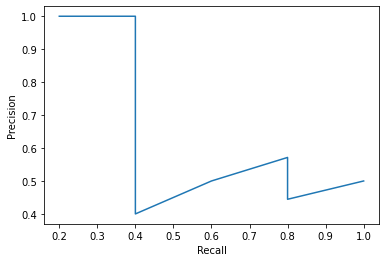

In [ ]:
# Code for the PR curve will be written here
import matplotlib.pyplot as plt

# example samples given in the blog post
ranked_corrects = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1])
recalls = []
precisions = []

total_poistives = np.sum(ranked_corrects)
running_positives = 0
count = 0
for p in ranked_corrects:
  count += 1
  running_positives += p
  recalls += [running_positives / total_poistives]
  precisions += [running_positives / count]

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Please elaborate on precision / recall tradeoff.

Write your answer to the cell below.

**Answer:**

If we use 0.7 instead of 0.5, then we would get higher precision but lower recall. That's why using the area under the curve is helpful to find a balance between both metrics.
If precision is far more critical, we use the mean average precision of detections (usually with 0.5 IoU).